In [1]:
pip install torcheval

Note: you may need to restart the kernel to use updated packages.


In [2]:
import kaggle
from pathlib import Path
from miniai.datasets import *
from datasets import Dataset

from fastai.vision.all import *
# Set up the Kaggle API credentials
kaggle.api.authenticate()

In [25]:
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [26]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

## Get Data

In [27]:
# Download the dataset
if not Path("data/hair_type").is_dir():
    kaggle.api.dataset_download_files('kavyasreeb/hair-type-dataset', path='data/hair_type', unzip=True)

In [28]:
hair_data = Path.cwd() / 'data/hair_type/data'

In [29]:
hair_data.ls()

(#5) [Path('/notebooks/data/hair_type/data/kinky'),Path('/notebooks/data/hair_type/data/dreadlocks'),Path('/notebooks/data/hair_type/data/curly'),Path('/notebooks/data/hair_type/data/Wavy'),Path('/notebooks/data/hair_type/data/Straight')]

## Create Dataloaders

In [57]:
# Define the transformations to apply to the images

transform = transforms.Compose([
    transforms.Resize((168,168 )),  # Resize the images to a consistent size
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
])

# Specify the path to the data folder
data_dir = Path.cwd() / 'data/hair_type/data'

# Create the dataset
dataset = ImageFolder(data_dir, transform=transform)

# Split the dataset into train and validation sets
train_ratio = 0.8  # Adjust this value to change the train-validation split ratio
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create the data loaders
batch_size = 32
num_workers = 4
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

dls = DataLoaders(train_dl, val_dl)

In [59]:
xb, yb = next(iter(dls.train))

In [60]:
xb.shape

torch.Size([32, 3, 168, 168])

In [61]:
dataset.class_to_idx

{'Straight': 0, 'Wavy': 1, 'curly': 2, 'dreadlocks': 3, 'kinky': 4}

## Create Learner

In [62]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [65]:
# need to account for 5 classes and not 10
get_model??

Signature:
get_model(
    act=<class 'torch.nn.modules.activation.ReLU'>,
    nfs=None,
    norm=None,
)
Docstring: <no docstring>
Source:   
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],5, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)
File:      /tmp/ipykernel_2138/3036874097.py
Type:      function


In [77]:
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],5, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

In [78]:
nfs = [3, 8, 16, 32, 64] # accept RGB
model = get_model(act_gr, nfs=nfs, norm=nn.BatchNorm2d, ).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs, opt_func=optim.AdamW, )

accuracy,loss,epoch,train
0.230,1.842,0,train
0.231,1.652,0,eval
0.269,1.601,1,train
0.194,1.644,1,eval
0.285,1.571,2,train
0.216,1.747,2,eval


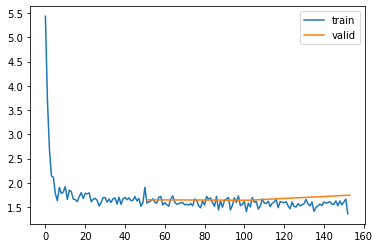

In [79]:
learn.fit(3)

In [81]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

AttributeError: 'Sequential' object has no attribute 'act_means'

## Try with Timm

attempt to use preset network to improve results

In [72]:
import timm
# from timm.models.resnet import BasicBlock, ResNet, Bottleneck

In [73]:
model = timm.create_model('resnet18d', in_chans=3, num_classes=5)

In [74]:
lr, epochs = 2e-2, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.365,1.488,0,train
0.403,1.458,1,train
0.501,1.264,2,train
0.597,1.044,3,train
0.645,0.899,4,train


ValueError: Tried to step 257 times. The specified number of total steps is 255

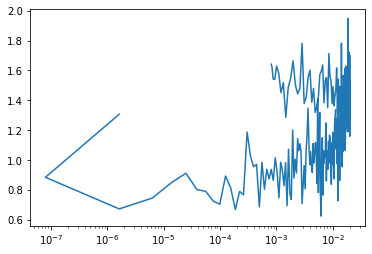

In [75]:
learn.fit(3)

accuracy,loss,epoch,train
0.714,0.726,0,train
0.493,1.648,0,eval
0.655,0.881,1,train
0.448,1.762,1,eval
0.693,0.796,2,train
0.408,2.531,2,eval


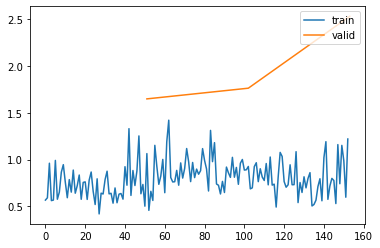

In [51]:
learn.fit(3)